In [1]:
import pandas as pd
import numpy as  np
import matplotlib.pylab as plt
import string  

### 读入表


In [2]:
tab1 = "./hair_dryer.tsv"
print(tab1)

#reviews = pd.read_csv(tab1, sep='\t', header=0,low_memory=False)
reviews = pd.read_csv(tab1, sep='\t', low_memory=False)
reviews.columns = ['marketplace','customer_id', 'review_id', 'product_id', 'product_parent', 'product_title', 'product_category', 
                   'star_rating','helpful_votes', 'total_votes','vine',
                   'verified_purchase','review_headline','review_body','review_date']

./hair_dryer.tsv


In [3]:
reviews.nunique()




marketplace              1
customer_id          11348
review_id            11470
product_id             538
product_parent         473
product_title          503
product_category         1
star_rating              5
helpful_votes          111
total_votes            119
vine                     2
verified_purchase        2
review_headline       7696
review_body          11197
review_date           2307
dtype: int64

Total ratings : 11470
Total users : 11348
Users giving bulk ratings (more than 10) : 0
Bulk ratings : 8
Populations of bulk ratings : 0.06974716652136007
Populations of bulk users : 0.0


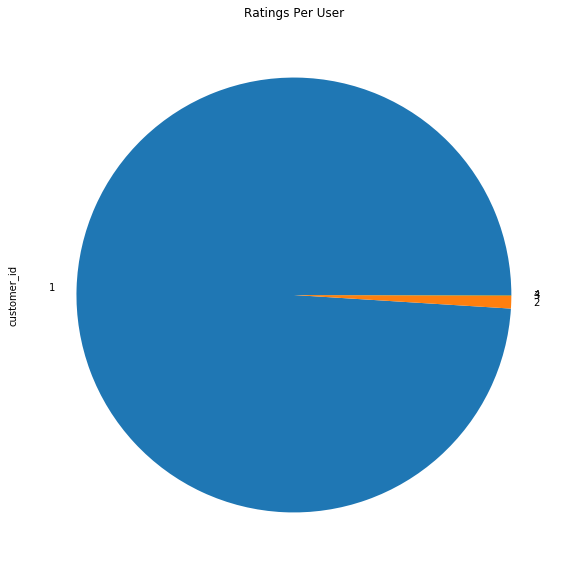

In [4]:
rating_perperson=reviews.customer_id.value_counts()
print ("Total ratings : " + str(sum(rating_perperson)))
print ("Total users : " + str(len(rating_perperson)))
print("Users giving bulk ratings (more than 10) : " + str(sum(rating_perperson >10)))
bulk = rating_perperson[rating_perperson >3]
bulk_rating = sum(bulk)
print ("Bulk ratings : " + str(bulk_rating))
print ("Populations of bulk ratings : " + str(bulk_rating*100/sum(rating_perperson)))
print ("Populations of bulk users : " + str(sum(rating_perperson >10)*100/len(rating_perperson)))
rating_perperson.value_counts().plot(kind='pie',figsize=(10,10), title='Ratings Per User')

*** Rating distribution ***
5    6704
4    2096
1    1032
3     999
2     639
Name: star_rating, dtype: int64


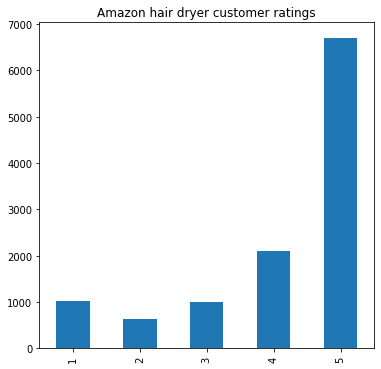

In [5]:
from matplotlib import pyplot
%matplotlib inline

star = reviews.star_rating.value_counts()
print("*** Rating distribution ***")
print(star)
star.sort_index(inplace=True)
star.plot(kind='bar',title='Amazon hair dryer customer ratings',figsize=(6,6),style='Solarize_Light2')

### NPS

Net Promoters Score helps us evaluate customer satisfaction and loyalty
Rating 1,2,3 - Detractors
Rating 4 - Passive
Rating 5 - Promoters

In [6]:
NPS_score = round (100*((star.loc[4:5])-sum(star.loc[1:2]))/sum(star.loc[:]),2)
print (" NPS score of hair dryer is : "  + str(NPS_score))

 NPS score of hair dryer is : 4     3.71
5    43.88
Name: star_rating, dtype: float64


### 得到邀请的人数

In [7]:
reviews.vine.value_counts()

### 得到邀请和未到邀请的比较

N    11291
Y      179
Name: vine, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x106874940>,
      dtype=object)

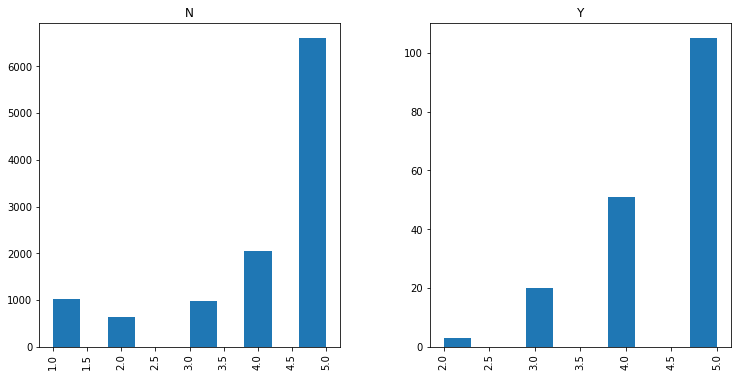

In [8]:
reviews.star_rating.hist(by=reviews.vine,figsize=(12,6))


### 确认购买的人数

In [9]:
reviews.verified_purchase.value_counts()

### 得到邀请和未到邀请的比较

Y    9811
N    1659
Name: verified_purchase, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x11553c080>,
      dtype=object)

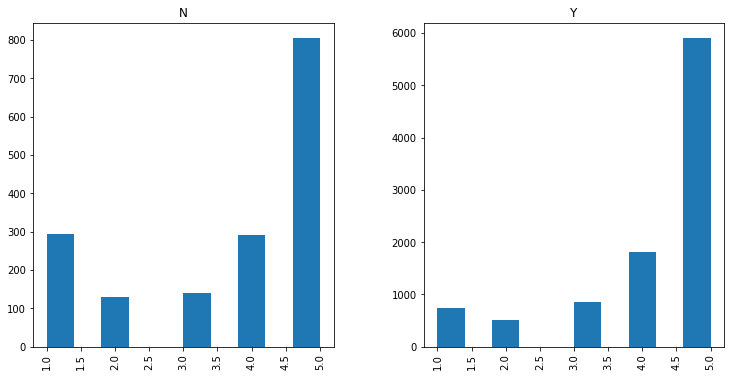

In [10]:
reviews.star_rating.hist(by=reviews.verified_purchase,figsize=(12,6))


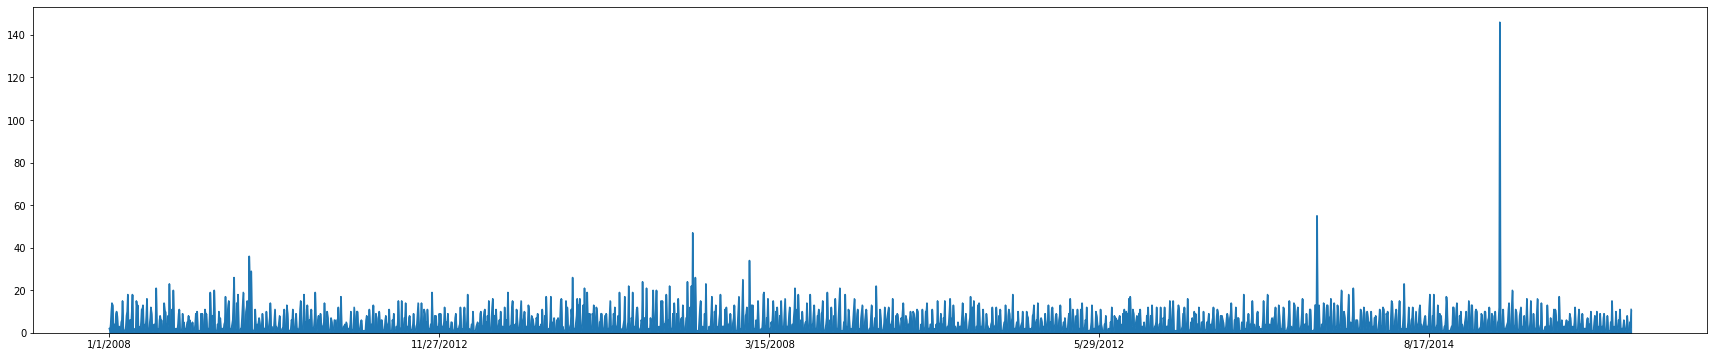

In [11]:
reviews['temp'] = reviews.review_date.apply(lambda x : pd.to_datetime(x))
review_dates = reviews.review_date.value_counts()
review_dates.sort_index(inplace=True)
review_dates.plot(kind='area',figsize=(30,6))

### 对前100数量的日期按月份统计

In [12]:
rating_perdate = review_dates.sort_values(ascending=False)
peakrating = rating_perdate[:100]
peak_month=[]
for x in peakrating.index:
    peak_month.append(pd.to_datetime(x).month)
pd.Series(peak_month).value_counts()


 

2     19
3     15
12    14
1     14
8      6
7      6
6      6
4      5
11     4
9      4
5      4
10     3
dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115b13f60>]],
      dtype=object)

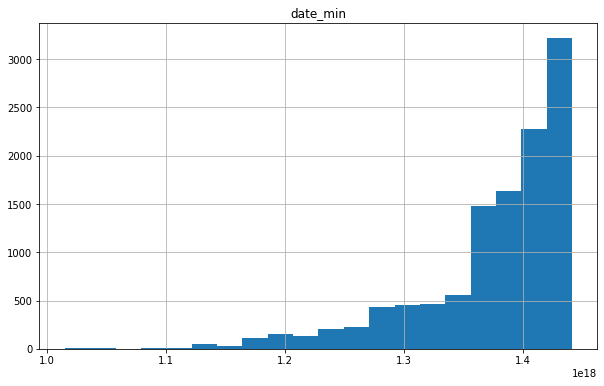

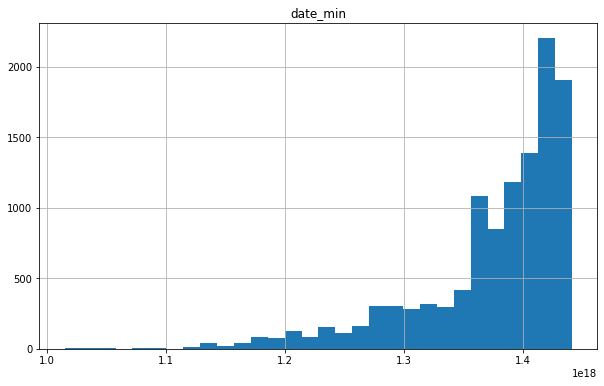

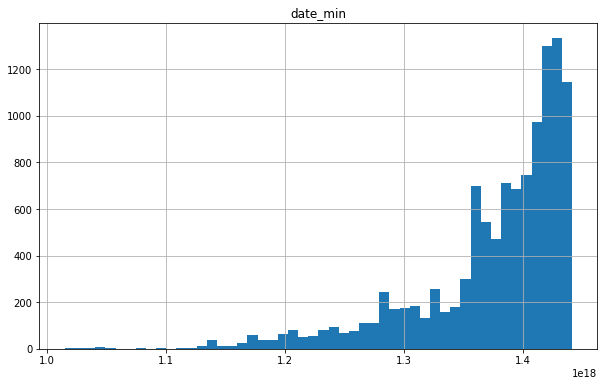

In [13]:
rating_series = pd.DataFrame(reviews.review_date)
dforms=[]
for x in rating_series.review_date:
    dforms.append((pd.to_datetime(x)).value)
# now we have dforms which has dates transformed to numeric values
rating2 = rating_series.assign(date_min = dforms)
rating2.reset_index(inplace=True)
#rating2.set_index('date_min')
#rating2.columns=['timestamp_string','review_count','date_min']
bins = np.linspace(min(rating2.date_min),max(rating2.date_min),num=50)
rating2.hist(column='date_min', bins=20,figsize=(10,6),)
rating2.hist(column='date_min', bins=30,figsize=(10,6))
rating2.hist(column='date_min', bins=50,figsize=(10,6))

In [14]:
def NPS_eval (A):
    score =0
    for x in A[:]:
        if (x>4) :
            score+=1
        elif (x<4) :
            score-=1
    return 100*score/len(A)  

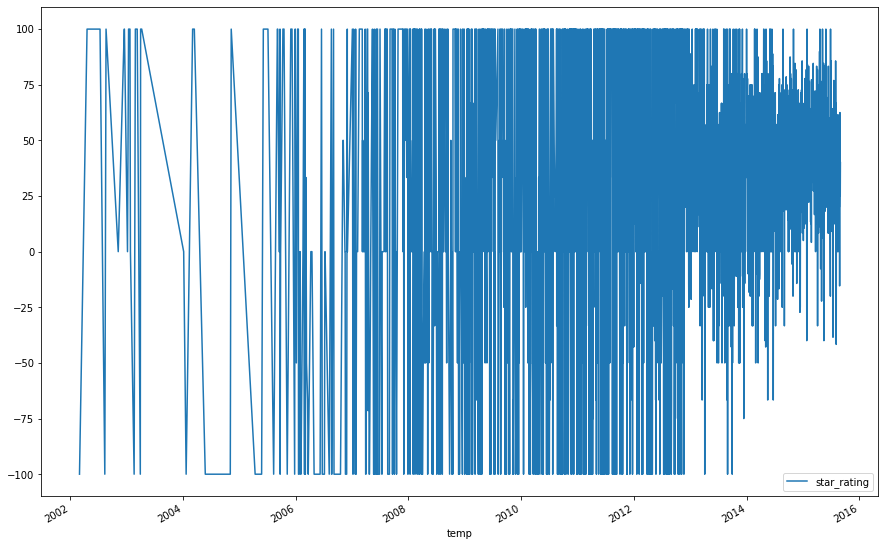

In [15]:
NPS_overtime = reviews[['temp','star_rating']]
NPS_overtime.groupby(by='temp').agg(NPS_eval).plot(figsize=(15,10))


AxesSubplot(0.125,0.125;0.775x0.755)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,star_rating
timeline,
11,-22.222222
21,-11.111111
40,-10.000000
16,3.703704
19,4.347826
...,...
74,47.667343
71,49.068323
6,50.000000


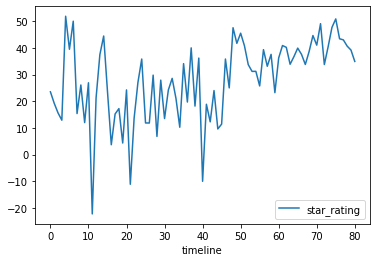

In [16]:
NPS_overtime['timeline']= NPS_overtime['temp'].apply(lambda x : (x.month+(12*(x.year-2009))))
#NPS_overtime['timeline']= NPS_overtime['temp'].apply(lambda x : (x.month+x.year*100))
NPS_overtime=NPS_overtime.loc[NPS_overtime['timeline']>=0]
NPS_by_month= NPS_overtime.groupby(by='timeline').agg(NPS_eval)

print(NPS_by_month.plot())
NPS_by_month.sort_values(by='star_rating')

### LSTM

In [17]:
import numpy
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import  pandas as pd
import  os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, load_model

Using TensorFlow backend.


In [18]:
dataset = NPS_by_month
dataset = dataset.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

train_size = int(len(dataset) * 0.90)
trainlist = dataset[:train_size]
testlist = dataset[train_size:]

In [19]:
def create_dataset(dataset, look_back):
#这里的look_back与timestep相同
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return numpy.array(dataX),numpy.array(dataY)
#训练数据太少 look_back并不能过大

#训练数据太少 look_back并不能过大

In [20]:
look_back = 1
trainX,trainY  = create_dataset(trainlist,look_back)
testX,testY = create_dataset(testlist,look_back)

In [21]:
trainX = numpy.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = numpy.reshape(testX, (testX.shape[0], testX.shape[1] ,1 ))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
model.save(os.path.join("Test" + ".h5"))

Epoch 1/100
 - 0s - loss: 0.4527
Epoch 2/100
 - 0s - loss: 0.3405
Epoch 3/100
 - 0s - loss: 0.2372
Epoch 4/100
 - 0s - loss: 0.1360
Epoch 5/100
 - 0s - loss: 0.0682
Epoch 6/100
 - 0s - loss: 0.0426
Epoch 7/100
 - 0s - loss: 0.0373
Epoch 8/100
 - 0s - loss: 0.0369
Epoch 9/100
 - 0s - loss: 0.0370
Epoch 10/100
 - 0s - loss: 0.0369
Epoch 11/100
 - 0s - loss: 0.0370
Epoch 12/100
 - 0s - loss: 0.0370
Epoch 13/100
 - 0s - loss: 0.0369
Epoch 14/100
 - 0s - loss: 0.0368
Epoch 15/100
 - 0s - loss: 0.0368
Epoch 16/100
 - 0s - loss: 0.0371
Epoch 17/100
 - 0s - loss: 0.0370
Epoch 18/100
 - 0s - loss: 0.0371
Epoch 19/100
 - 0s - loss: 0.0370
Epoch 20/100
 - 0s - loss: 0.0368
Epoch 21/100
 - 0s - loss: 0.0367
Epoch 22/100
 - 0s - loss: 0.0372
Epoch 23/100
 - 0s - loss: 0.0372
Epoch 24/100
 - 0s - loss: 0.0368
Epoch 25/100
 - 0s - loss: 0.0369
Epoch 26/100
 - 0s - loss: 0.0368
Epoch 27/100
 - 0s - loss: 0.0372
Epoch 28/100
 - 0s - loss: 0.0370
Epoch 29/100
 - 0s - loss: 0.0369
Epoch 30/100
 - 0s - lo

In [22]:
#model = load_model(os.path.join("DATA","Test" + ".h5"))
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

#反归一化
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(trainY)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(testY)

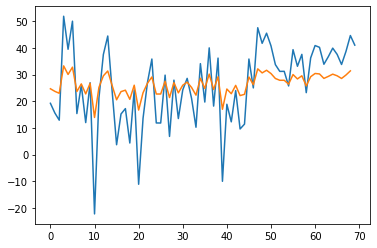

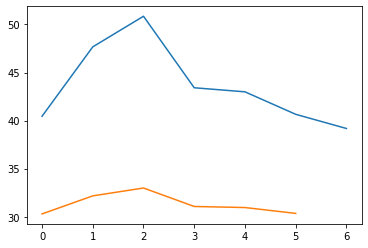

In [23]:
plt.plot(trainY)
plt.plot(trainPredict[1:])
plt.show()
plt.plot(testY)
plt.plot(testPredict[1:])
plt.show()



### arima
下面是arima

In [24]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

In [25]:
df = NPS_by_month

ts = df['star_rating'] 


ts.head()

timeline
0    23.529412
1    19.230769
2    15.625000
3    12.903226
4    51.851852
Name: star_rating, dtype: float64

In [26]:

# 移动平均图
def draw_trend(timeseries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeseries.rolling(window=size).mean()
    # 对size个数据移动平均的方差
    rol_std = timeseries.rolling(window=size).std()
 
    timeseries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_std.plot(color='black', label='Rolling standard deviation')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')

In [27]:
def draw_ts(timeseries):
    f = plt.figure(facecolor='white')
    timeseries.plot(color='blue')
    plt.show()


In [28]:

def teststationarity(ts):
    dftest = adfuller(ts)
    # 对上述函数求得的值进行语义描述
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    return dfoutput

下面查看均值和方差

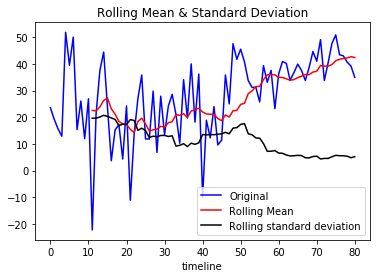

In [29]:
draw_trend(ts,12)

看Dickey-Fuller的结果

In [30]:
teststationarity(ts)

Test Statistic                 -2.002011
p-value                         0.285692
#Lags Used                      4.000000
Number of Observations Used    76.000000
Critical Value (1%)            -3.519481
Critical Value (5%)            -2.900395
Critical Value (10%)           -2.587498
dtype: float64

对数变换

In [31]:
ts_log = np.log(ts+50)

根据平滑技术的不同，平滑法具体分为移动平均法和指数平均法。

移动平均即利用一定时间间隔内的平均值作为某一期的估计值，而指数平均则是用变权的方法来计算均值。

移动平均：

In [32]:
def draw_moving(timeSeries, size):
    f = plt.figure(facecolor='white')
    # 对size个数据进行移动平均
    rol_mean = timeSeries.rolling(window=size).mean()
    # 对size个数据进行加权移动平均
    #rol_weighted_mean = timeSeries.ewm(span=size)
    rol_weighted_mean=timeSeries.ewm(halflife=size,min_periods=0,adjust=True,ignore_na=False).mean()
 
    timeSeries.plot(color='blue', label='Original')
    rol_mean.plot(color='red', label='Rolling Mean')
    rol_weighted_mean.plot(color='black', label='Weighted Rolling Mean')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show()

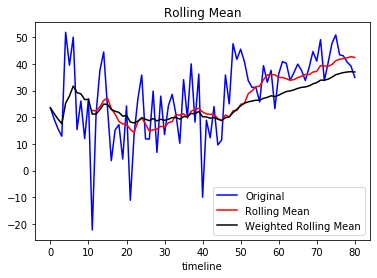

In [33]:
draw_moving(ts,12)

差分

In [34]:
diff_12 = ts_log.diff(12)
diff_12.dropna(inplace=True)
diff_12_1 = diff_12.diff(1)
diff_12_1.dropna(inplace=True)
teststationarity(diff_12_1)


Test Statistic                -9.993546e+00
p-value                        1.967216e-17
#Lags Used                     2.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64

分解

In [35]:

def decompose(timeseries):
    
    # 返回包含三个部分 trend（趋势部分） ， seasonal（季节性部分） 和residual (残留部分)
    decomposition = seasonal_decompose(timeseries)
    
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    
    plt.subplot(411)
    plt.plot(ts_log, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    return trend , seasonal, residual

In [36]:
trend , seasonal, residual = decompose(ts_log)
residual.dropna(inplace=True)
draw_trend(residual,12)
teststationarity(residual)

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

### 预测

In [37]:
rol_mean = ts_log.rolling(window=12).mean()
rol_mean.dropna(inplace=True)
ts_diff_1 = rol_mean.diff(1)
ts_diff_1.dropna(inplace=True)
teststationarity(ts_diff_1)

Test Statistic                 -3.370580
p-value                         0.012004
#Lags Used                     11.000000
Number of Observations Used    57.000000
Critical Value (1%)            -3.550670
Critical Value (5%)            -2.913766
Critical Value (10%)           -2.594624
dtype: float64

In [38]:
ts_diff_2 = ts_diff_1.diff(1)
ts_diff_2.dropna(inplace=True)
teststationarity(ts_diff_2)

Test Statistic                -9.993546e+00
p-value                        1.967216e-17
#Lags Used                     2.000000e+00
Number of Observations Used    6.500000e+01
Critical Value (1%)           -3.535217e+00
Critical Value (5%)           -2.907154e+00
Critical Value (10%)          -2.591103e+00
dtype: float64

In [39]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
def draw_acf_pacf(ts,lags):
    f = plt.figure(facecolor='white')
    ax1 = f.add_subplot(211)
    plot_acf(ts,ax=ax1,lags=lags)
    ax2 = f.add_subplot(212)
    plot_pacf(ts,ax=ax2,lags=lags)
    plt.subplots_adjust(hspace=0.5)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


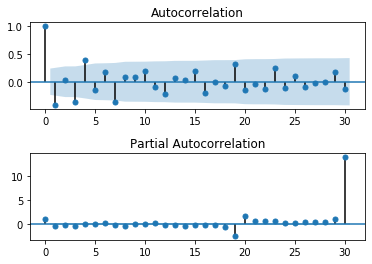

In [40]:
draw_acf_pacf(ts_diff_2,30)

In [41]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(ts_diff_1, order=(1,1,1)) 
result_arima = model.fit( disp=-1, method='css')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:214: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [44]:
predict_ts = result_arima.predict()
# 一阶差分还原
diff_shift_ts = ts_diff_1.shift(1)
diff_recover_1 = predict_ts.add(diff_shift_ts)
# 再次一阶差分还原
rol_shift_ts = rol_mean.shift(1)
diff_recover = diff_recover_1.add(rol_shift_ts)
# 移动平均还原
rol_sum = ts_log.rolling(window=11).sum()
rol_recover = diff_recover*12 - rol_sum.shift(1)
# 对数还原
log_recover = np.exp(rol_recover)-50
log_recover.dropna(inplace=True)

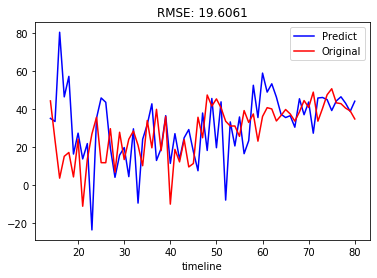

In [45]:
ts = ts[log_recover.index]  # 过滤没有预测的记录plt.figure(facecolor='white')
log_recover.plot(color='blue', label='Predict')
ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
plt.show()

In [ ]:
print('google')
